# Chaper 3. Linear Neural Networks

## Linear Regression

- 의존적인 하나의 변수(Output) <-> 하나 혹은 다수의 독립적 변수들(Input)간의 관계를 모델링하는 것.
- Input과 Output간의 관계의 특성을 추출하는 것. 
- Numerical Value를 예측하는 경우 주로 사용됨.

### Linear Model
- 선형성 가정 (Linearity Assumption)
  > 어떤 문제에 대한 입력과 출력간의 관계가 선형 함수의 합에 의해 표현 될 수 있다. (weighted sum of features)
  
### Loss Function
- a Measure of fitness of model
- Training
  > optimal paramters = argmin Loss(w,b) => Loss 함수를 최소로만드는 parameter를 찾는것.
- 특이하게도 Linear Regression의 loss function을 최소화하는 문제는 분석적 방식으로 closed form을 유도할 수 있음. 


  



## Minibatch / SGD
- 선형 회귀와 같이 분석적인 방식으로 Optimal을 유도할 수 없어도 training이 가능한데 
- 간단히 말해서 loss function을 감소시키는 방향으로 점진적으로 파라미터를 업데이트해나가면 되는데 
- 이것이 Gradient Descent 
- Naive Gradient Descent 
  - 데이터셋의 모든 예시에 대해 Loss값의 평균을 구하고
  - 이렇게 얻은 평균에 대해 편미분을 구하여 paramer를 업데이트 
  - 한번 업데이트 하는데 모든 데이터를 다 훑어야 함 => 너무 느림
- Random Sampling 된 Batch를 Update의 기본 단위로하여 절충 => SGD
- Steps of Gradient Descent 
  - 파라미터 초기화 (Initialize weight and bias)
  - 각 batch에 대한 loss 대표값을 구함 (Calculate average loss for each batch (minibatch))
  - loss function에 대한 미분을 구하고 (Calculate derivitive)
  - 미분의 값에 learning rate를 반영하여 파라미터 업데이트 (paramtersUpdate parameters with amount of learning rate)
  - 미리 정한 횟수(epoch)만큼 위 학습을 반복함
- 여기서 learning rate나 batch size 같은 건 학습과정에 update되는 parameter가 아님.  => Hyperparamters

- Linear Regression은 하나의 Minimum이 존재하지만
- 보다 복잡한 모델이나 Deep Networks는 그렇지 않음
  > Hyperparamters 등의 tuning을 통해 loss function이 최소화 되는 조건을 찾아야 함
  



  

  
  

In [31]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# generate synthetic data 

def synthetic_data(w, b, num_samples): #@save
    X = torch.normal(0, 1, (num_samples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

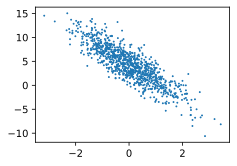

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

d2l.set_figsize()

d2l.plt.scatter(features[:,(1)].detach().numpy(), labels.detach().numpy(), 1)

In [39]:
# chop dataset into mini batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [40]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3161,  0.6896],
        [ 0.8479,  0.3523],
        [ 0.0338,  0.5933],
        [-0.5410,  0.3048],
        [-0.5494,  0.5204],
        [-0.3241,  0.1652],
        [ 0.7258,  0.6448],
        [-0.4174, -0.6200],
        [ 0.0702, -1.2007],
        [-1.8209, -0.2068]]) 
 tensor([[1.2036],
        [4.6973],
        [2.2436],
        [2.0740],
        [1.3415],
        [2.9660],
        [3.4691],
        [5.4640],
        [8.4075],
        [1.2445]])


In [56]:
# initialize paramters
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define model
def linreg(X, w, b): #@save
    return torch.mm(X,w) + b

In [47]:
def squared_loss(y_hat, y): #@save
    return (y_hat - y) ** 2 / 2

In [50]:
def sgd(params, lr, batch_size): #@save
    with torch.no_grad():    # disable gradient update 
        for param in params:
            param -= lr * param.grad / batch_size   # update parameters with gradient 
            param.grad.zero_()                      # set gradient to zero
    

In [52]:
# hyper parameters 
lr = 0.03 
num_epochs = 3
net = linreg
loss = squared_loss


In [57]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039157
epoch 2, loss 0.000146
epoch 3, loss 0.000048


In [61]:
print(f'error in w : {true_w - w.reshape(true_w.shape)}')
print(f'error in b : {true_b - b}')

error in w : tensor([ 0.0003, -0.0005], grad_fn=<SubBackward0>)
error in b : tensor([0.0008], grad_fn=<RsubBackward1>)


---
## Linear Regression using more PyTorch API


In [63]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [71]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features ,labels = d2l.synthetic_data(true_w, true_b, 1000)

In [76]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


In [78]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [79]:
next(iter(data_iter))

[tensor([[-1.1173, -0.3688],
         [-0.8666, -0.4940],
         [-0.4476, -1.1426],
         [ 1.6796,  1.3246],
         [ 0.1867, -0.4542],
         [-0.6351, -0.4539],
         [ 1.0691,  0.7836],
         [-0.6862, -0.3856],
         [-0.1263, -0.6634],
         [-0.0542,  0.0830]]),
 tensor([[3.2178],
         [4.1207],
         [7.1906],
         [3.0591],
         [6.1061],
         [4.4745],
         [3.6767],
         [4.1449],
         [6.1996],
         [3.8055]])]

In [81]:
# define Model
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

In [86]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [89]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [93]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in iter(data_iter):
        l = loss(y, net(X))
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch = {epoch}, l = {l:f}')
        

epoch = 0, l = 0.000096
epoch = 1, l = 0.000096
epoch = 2, l = 0.000096


## Softmax Regression
- classification 문제 (스팸 분류, dog/cat..)
- hard assignment 
  > 입력에 대한 class를 예측
- soft assignment 
  > 입력에 대한 class의 확률을 예측 
> 실제 hard assignment를 구현하는데 있어서 soft assignment를 활용하기도 하기 때문에 이러한 구분은 큰 의미가 없어짐

